In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
# For portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, EfficientFrontier

In [8]:
# Download historical data for TSLA, BND, SPY
assets = ["TSLA", "BND", "SPY"]
data = yf.download(assets, start="2015-07-01", end="2025-07-31")

/tmp/ipython-input-558424288.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start="2015-07-01", end="2025-07-31")
[*********************100%***********************]  3 of 3 completed


## Compute Historical Daily Returns

In [9]:
# Daily returns
daily_returns = data['Close'].pct_change().dropna()

In [27]:

forecasted_tsla_annual_return = -0.211063  # -21.1% annualized

# Historical annualized returns for BND & SPY
historical_returns_annual = daily_returns.mean() * 252

# Create expected returns series
Annualized_returns = pd.Series({
    'TSLA': forecasted_tsla_annual_return,
    'BND': historical_returns_annual['BND'],
    'SPY': historical_returns_annual['SPY']
})

Annualized_returns

,0
TSLA,-0.211063
BND,0.019599
SPY,0.144844


## Covariance Matrix (Annualized)

In [13]:
# Annualized covariance matrix
cov_matrix = daily_returns.cov() * 252
cov_matrix

Ticker,BND,SPY,TSLA
Ticker,,,
BND,0.003016,0.001150,0.001861
SPY,0.001150,0.033272,0.052950
TSLA,0.001861,0.052950,0.350331


## optimization simulation to generate the Efficient Frontier

In [28]:
# Generate random portfolios
num_portfolios = 10000
assets = data["Close"].columns
n_assets = len(assets)

np.random.seed(42)
weights = np.random.dirichlet(np.ones(n_assets), num_portfolios)
returns=np.dot(weights,Annualized_returns)
stddevs = np.sqrt(np.diag(weights @ cov_matrix @ weights.T))
sharpe_ratios = returns / stddevs  # Assuming risk-free rate = 0

# Find min volatility and max Sharpe portfolios
min_vol_idx = np.argmin(stddevs)
max_sharpe_idx = np.argmax(sharpe_ratios)

# Random portfolios results
random_portfolios = [
    {'weights': w, 'return': r, 'stddev': s, 'sharpe': sr}
    for w, r, s, sr in zip(weights, returns, stddevs, sharpe_ratios)
]

# Use PyPortfolioOpt to get EXACT optimal portfolios

# Minimum Volatility Portfolio
ef_minvol = EfficientFrontier(Annualized_returns, cov_matrix)
ef_minvol.min_volatility()
min_vol_weights = ef_minvol.clean_weights()
min_vol_return, min_vol_stddev, _ = ef_minvol.portfolio_performance()

# Maximum Sharpe Portfolio
ef_maxsharpe = EfficientFrontier(Annualized_returns, cov_matrix)
ef_maxsharpe.max_sharpe()
max_sharpe_weights = ef_maxsharpe.clean_weights()
max_sharpe_return, max_sharpe_stddev, _ = ef_maxsharpe.portfolio_performance()

# Compile results into a dictionary
ef_results = {
    'random_portfolios': random_portfolios,
    'min_vol': {
        'weights': np.array([min_vol_weights[asset] for asset in assets]),
        'return': min_vol_return,
        'stddev': min_vol_stddev,
    },
    'max_sharpe': {
        'weights': np.array([max_sharpe_weights[asset] for asset in assets]),
        'return': max_sharpe_return,
        'stddev': max_sharpe_stddev,
    }
}


## Plot the Efficient Frontier

/tmp/ipython-input-1674329501.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  asset_ret = Annualized_returns[i]



Minimum Volatility Portfolio:
Expected Return: -19.84%
Expected Volatility: 5.40%
Sharpe Ratio: -3.68
Asset Allocation:
BND: 5.49%
SPY: 0.00%
TSLA: 94.51%

Maximum Sharpe Ratio Portfolio:
Expected Return: 14.48%
Expected Volatility: 59.19%
Sharpe Ratio: 0.24
Asset Allocation:
BND: 0.00%
SPY: 100.00%
TSLA: 0.00%


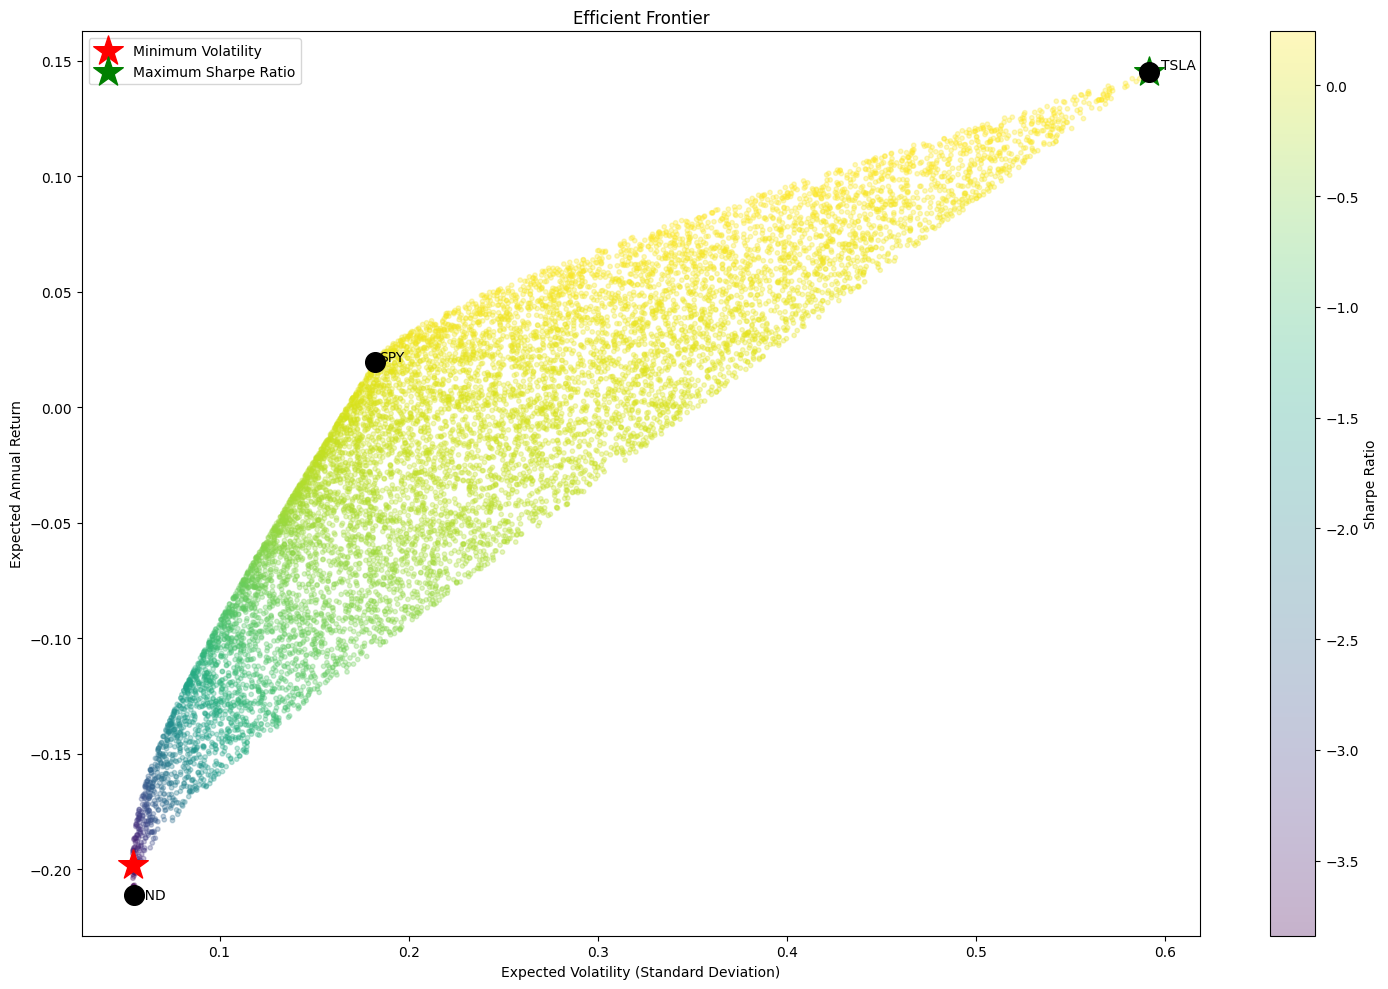

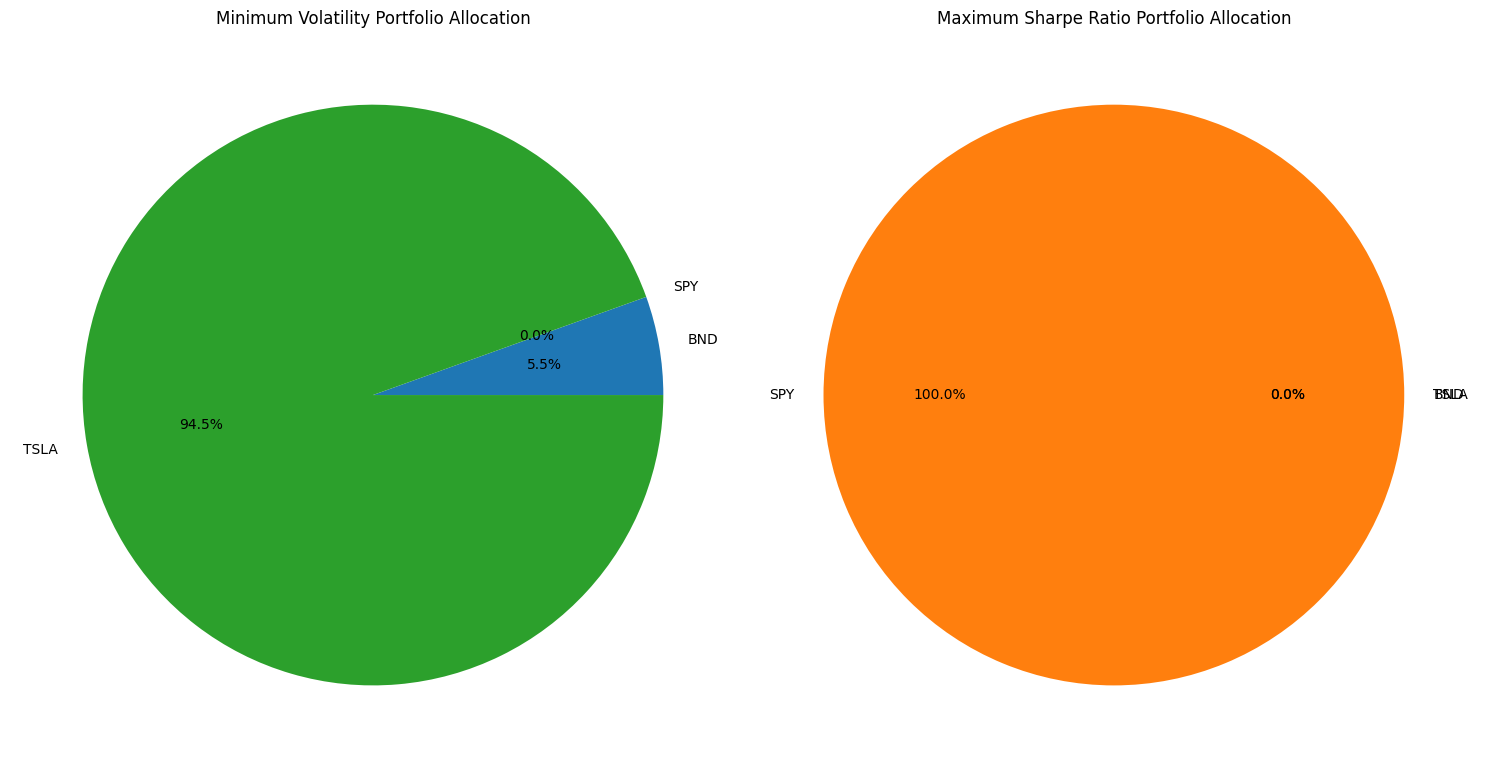

In [30]:
# Plot Efficient Frontier
plt.figure(figsize=(15, 10))
returns = [p['return'] for p in ef_results['random_portfolios']]
stddevs = [p['stddev'] for p in ef_results['random_portfolios']]

plt.scatter(stddevs, returns, c=np.array(returns)/np.array(stddevs),
            marker='o', cmap='viridis', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Plot optimal portfolios
plt.scatter(ef_results['min_vol']['stddev'], ef_results['min_vol']['return'],
            marker='*', color='r', s=500, label='Minimum Volatility')
plt.scatter(ef_results['max_sharpe']['stddev'], ef_results['max_sharpe']['return'],
            marker='*', color='g', s=500, label='Maximum Sharpe Ratio')

# Plot individual assets
for i, asset in enumerate(assets):
    asset_vol = np.sqrt(cov_matrix.iloc[i, i])
    asset_ret = Annualized_returns[i]
    plt.scatter(asset_vol, asset_ret, marker='o', s=200, color='black')
    plt.annotate(asset, (asset_vol*1.01, asset_ret*1.01))

plt.title('Efficient Frontier')
plt.xlabel('Expected Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.tight_layout()

# Print Portfolio Weights & Metrics
print("\nMinimum Volatility Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['min_vol']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['min_vol']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['min_vol']['return']/ef_results['min_vol']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['min_vol']['weights'][i]:.2%}")

print("\nMaximum Sharpe Ratio Portfolio:")
print("Expected Return: {:.2%}".format(ef_results['max_sharpe']['return']))
print("Expected Volatility: {:.2%}".format(ef_results['max_sharpe']['stddev']))
print("Sharpe Ratio: {:.2f}".format(ef_results['max_sharpe']['return']/ef_results['max_sharpe']['stddev']))
print("Asset Allocation:")
for i, asset in enumerate(assets):
    print(f"{asset}: {ef_results['max_sharpe']['weights'][i]:.2%}")

# Plot Asset Allocations
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.pie(ef_results['min_vol']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Minimum Volatility Portfolio Allocation')

plt.subplot(1, 2, 2)
plt.pie(ef_results['max_sharpe']['weights'], labels=assets, autopct='%1.1f%%')
plt.title('Maximum Sharpe Ratio Portfolio Allocation')

plt.tight_layout()
plt.show()